In [1]:
%matplotlib inline
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import binom
import pandas as pd
import numpy as np

from minavrfpy import lib

## single epoch

In [3]:
epoch = 20
bp_key = "B62qrQiw9JhUumq457sMxicgQ94Z1WD9JChzJu19kBE8Szb5T8tcUAC"

results = lib.get_epoch_df(epoch, block_producer_key=bp_key)

df = results['df']
stakes_df = results['stakes_df']

## outcome per epoch

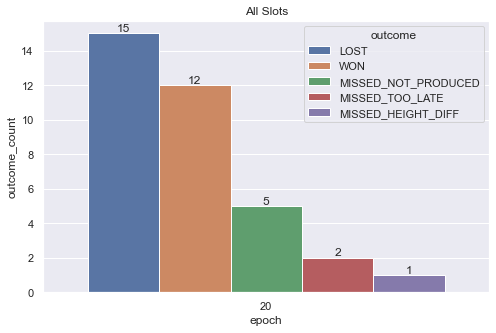

In [4]:
sns.set(rc={"figure.figsize": (8, 5)})


counts_df = (
    df.groupby("epoch")
    .outcome.value_counts()
    .to_frame()
    .rename(columns={"outcome": "outcome_count"})
    .reset_index()
)

ax = sns.barplot(x="epoch", y="outcome_count", data=counts_df, hue="outcome")
ax.set_title("All Slots")
for container in ax.containers:
    ax.bar_label(container)

## outcome grouped by super_charged

In [5]:
df.groupby(["epoch", "super_charged"]).outcome.value_counts()

epoch  super_charged  outcome            
20     False          LOST                    6
                      MISSED_NOT_PRODUCED     3
                      WON                     2
       True           WON                    10
                      LOST                    9
                      MISSED_NOT_PRODUCED     2
                      MISSED_TOO_LATE         2
                      MISSED_HEIGHT_DIFF      1
Name: outcome, dtype: int64

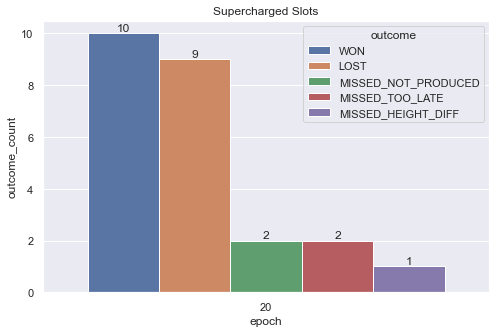

In [6]:
sns.set(rc={"figure.figsize": (8, 5)})


counts_df = (
    df[df.super_charged == True].groupby("epoch")
    .outcome.value_counts()
    .to_frame()
    .rename(columns={"outcome": "outcome_count"})
    .reset_index()
)

ax = sns.barplot(x="epoch", y="outcome_count", data=counts_df, hue="outcome")
ax.set_title("Supercharged Slots")
for container in ax.containers:
    ax.bar_label(container)

In [7]:
df[df.outcome == "MISSED_NOT_PRODUCED"]

,epoch,slot,global_slot,block,winner_exists,saw_my_producer,bp_won,block_time,received_time,winner_pk,super_charged,block_height_equal,too_late,min_bt,min_bt_minutes,outcome,next_block_in
2,20,275,143075,False,False,False,False,[],NaT,B62qrhxaun9CinfJobHb3uGp4vEXd3j2kg6iNhsWZnhDYz...,False,False,True,0 days,0.0,MISSED_NOT_PRODUCED,NaN
4,20,699,143499,98271,True,False,False,[],2022-01-09 23:00:13.498000+00:00,B62qmrv43yUzm2uKruCFhmmL4dUbFhKzbkAsXPBru7q5dy...,True,False,True,0 days,0.0,MISSED_NOT_PRODUCED,NaN
5,20,709,143509,False,False,False,False,[],NaT,B62qr5Kat2je68ni2TyEZiaPCf5iKPxCZPWjsEgdEJh9g3...,False,False,True,0 days,0.0,MISSED_NOT_PRODUCED,NaN
6,20,813,143613,98317,True,False,False,[],2022-01-10 04:42:17.031000+00:00,B62qkTvL5o8LqNb6AtVR84smE4qgTJh2uySj8ufQd8cG8Q...,False,False,True,0 days,0.0,MISSED_NOT_PRODUCED,NaN
7,20,852,143652,98334,True,False,False,[],2022-01-10 06:38:43.025000+00:00,B62qidNtQcb2hTiTy15LBLMbVJ2ArRTTyUArFMYZ6S4Cp8...,True,False,True,0 days,0.0,MISSED_NOT_PRODUCED,NaN


In [8]:
df[df.outcome == "MISSED_HEIGHT_DIFF"]

,epoch,slot,global_slot,block,winner_exists,saw_my_producer,bp_won,block_time,received_time,winner_pk,super_charged,block_height_equal,too_late,min_bt,min_bt_minutes,outcome,next_block_in
32,20,6968,149768,102237,True,True,False,[0 days 00:03:14.058000],2022-01-23 00:27:10.941000+00:00,B62qqsV17qyg3cSDb4qKt3kE6rYR2ZHvjvZDjNvs1TnUyP...,True,False,True,0 days 00:03:14.058000,3.233333,MISSED_HEIGHT_DIFF,NaN


In [9]:
df[df.outcome == "MISSED_TOO_LATE"]

,epoch,slot,global_slot,block,winner_exists,saw_my_producer,bp_won,block_time,received_time,winner_pk,super_charged,block_height_equal,too_late,min_bt,min_bt_minutes,outcome,next_block_in
13,20,2059,144859,False,False,True,False,[0 days 00:03:15.380000],NaT,B62qndm4TN6nvZqjeefvV1fExLK6AbQYsv6agyXAF8bG4C...,True,False,True,0 days 00:03:15.380000,3.250000,MISSED_TOO_LATE,NaN
14,20,2122,144922,False,False,True,False,[0 days 00:03:16.488000],NaT,B62qoGk73iqsnBbWNQ6uvQ68ufhYEBZVBXEYXAJjc9JPy3...,True,False,True,0 days 00:03:16.488000,3.266667,MISSED_TOO_LATE,NaN


## slot luck
try to visualize "slot luck"


epoch 20 - expected 41 slots - got 35... 


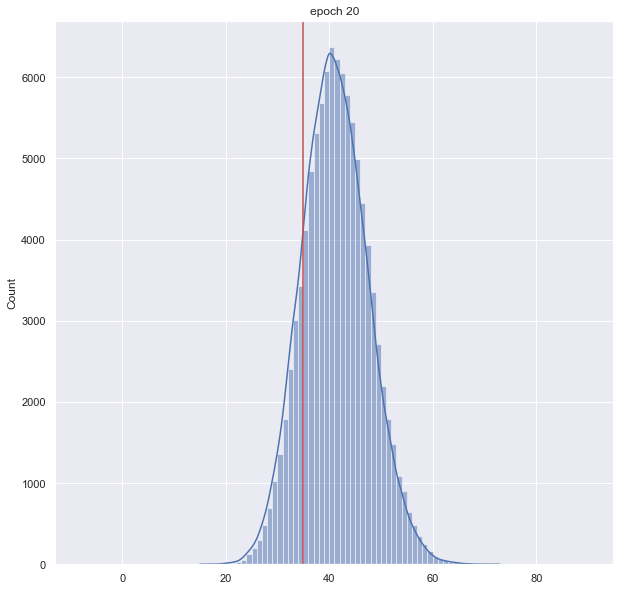

<Figure size 576x360 with 0 Axes>

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

SLOTS_PER_EPOCH = 7140

def get_slot_win_perc(stake, total_currency):
    return (1 - ((1 / 4) ** (stake / total_currency)))


epoch_data = []

total_currency = results['epoch_data']['total_currency']
total_staking_balance = results['stakes_df'].balance.sum()

slot_win_pct = get_slot_win_perc(
    total_staking_balance, total_currency
)    
expected_blocks_value = slot_win_pct * SLOTS_PER_EPOCH 

won_blocks = df[(df.epoch == epoch) & (df.outcome == 'WON')].block.count()
slots_won = df[(df.epoch == epoch)].slot.nunique()

data = binom.rvs(n=SLOTS_PER_EPOCH, p=slot_win_pct, size=100000)

k = np.arange(int(expected_blocks_value - 50), int(expected_blocks_value) + 50, 1)

plt.figure(epoch)

sns.histplot(data, kde=True, bins=k, ax=ax)
ax.axvline(slots_won, 0, 1, color="r")
ax.set_title(f"epoch {epoch}")

epoch_data.append({
    'epoch': epoch,
    'expected_slots': expected_blocks_value,
    'expected_slots_binom': binom(SLOTS_PER_EPOCH, slot_win_pct).expect(),
    'slot_win_pct': slot_win_pct,
    'won_slots': slots_won,
    'won_blocks': won_blocks,
    'orphan_rate': 1 - (won_blocks/slots_won)
})

print(f"epoch {epoch} - expected {round(expected_blocks_value)} slots - got {slots_won}... ")


plt.show()

In [11]:
epoch_slots_df = pd.DataFrame(epoch_data)

epoch_slots_df["cdf"] = epoch_slots_df.apply(
    lambda row: binom.cdf(row["won_slots"], SLOTS_PER_EPOCH, row["slot_win_pct"]),
    axis=1,
)
epoch_slots_df

,epoch,expected_slots,expected_slots_binom,slot_win_pct,won_slots,won_blocks,orphan_rate,cdf
0,20,41.101531,41.101531,0.005757,35,12,0.657143,0.19194
